In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.impute import SimpleImputer

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Preprocessing
- get rid of nulls
- encoding categorical data

In [4]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [5]:
# any one without a cabin just place None
train_df['Cabin'] = train_df['Cabin'].apply(lambda x: 'None' if pd.isna(x) else x)
test_df['Cabin'] = test_df['Cabin'].apply(lambda x: 'None' if pd.isna(x) else x)

In [6]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked        True
dtype: bool

In [7]:
# find the most common location embarked
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])

In [8]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [9]:
# Age is usually correlated with the amount of money they make and sex. 
# find the average age based on sex and passenger class (1st 2nd or 3rd)
corr_df = train_df.groupby(['Pclass', 'Sex']).Age.mean().reset_index()

def update_age(params):
    pclass = params.iloc[0]
    sex = params.iloc[1]
    age = params.iloc[2]
    if pd.isnull(age):
        age = float(corr_df[(corr_df['Pclass'] == pclass) & (corr_df['Sex'] == sex)]['Age'].iloc[0])
    return age

train_df['Age'] = train_df[['Pclass', 'Sex', 'Age']].apply(lambda x : update_age(x), axis = 1)

In [10]:
corr_df = test_df.groupby(['Pclass', 'Sex']).Age.mean().reset_index()

test_df['Age'] = test_df[['Pclass', 'Sex', 'Age']].apply(lambda x : update_age(x), axis = 1)

In [11]:
train_df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [12]:
test_df.isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin          False
Embarked       False
dtype: bool

In [13]:
corr_df = train_df.groupby(['Pclass']).Fare.mean().reset_index()

def update_fare(params):
    pclass = params.iloc[0]
    fare = params.iloc[1]
    if pd.isna(fare):
        fare = float(corr_df[(corr_df['Pclass'] == pclass)]['Fare'].iloc[0])
    return fare

test_df['Fare'] = test_df[['Pclass', 'Fare']].apply(lambda x : update_fare(x), axis = 1)

In [14]:
test_df.isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

In [15]:
# get rid of uneeded columns 
train_df = train_df.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin'])
test_df = test_df.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin'])
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Data Analysis

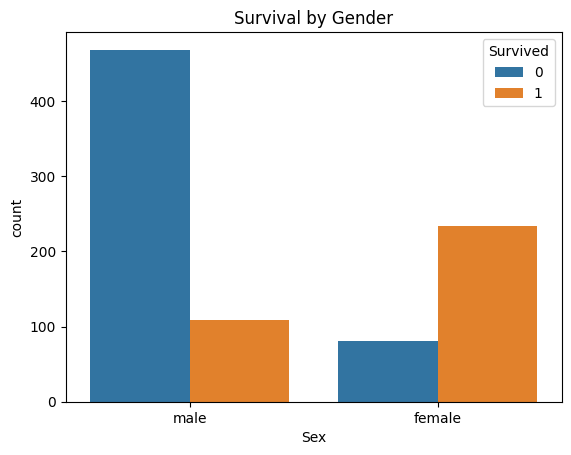

In [16]:
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title('Survival by Gender')
plt.show()

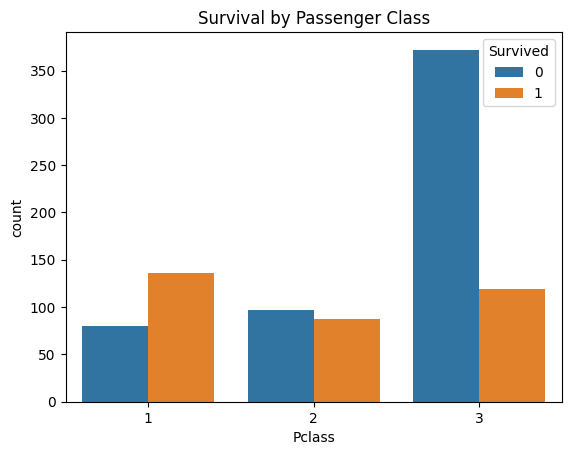

In [17]:
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Survival by Passenger Class')
plt.show()

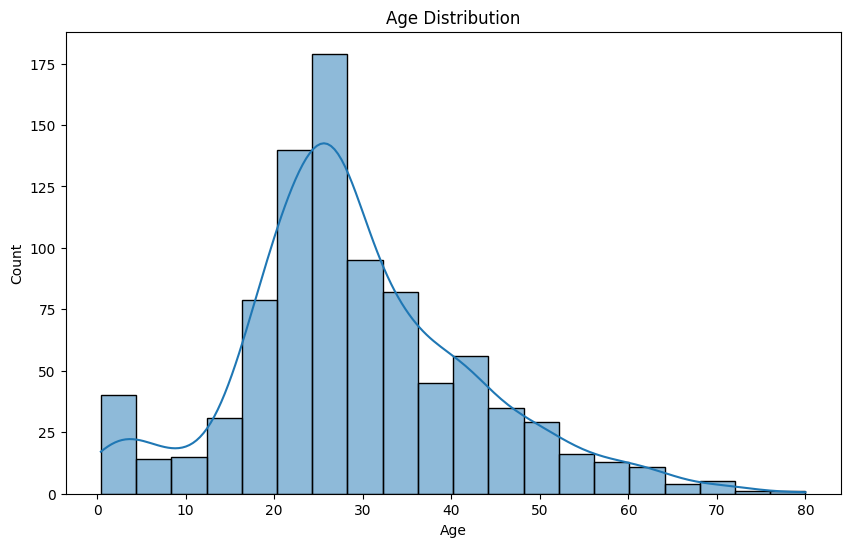

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='Age', bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [19]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.318643,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.281103,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.750000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,26.507589,0.000000,0.000000,14.454200
75%,1.000000,3.000000,36.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [20]:
train_df[['Age', 'Pclass']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Age', ascending=False)

,Pclass,Age
0,1,38.378866
1,2,29.907295
2,3,25.112288


In [21]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


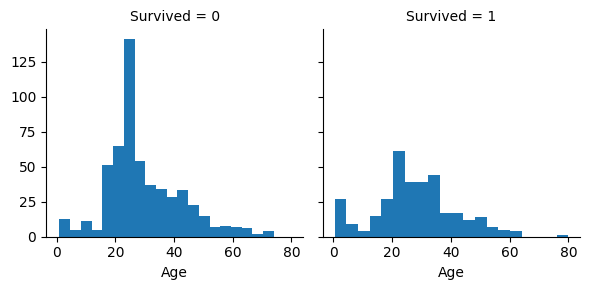

In [22]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

## One hot encode categorical data 
- take text data like Sex and Embarked and split them into binary columns of different cateories
- aka one hot encoding

In [23]:
# one hot encode sex and embarked columns
encoder = OneHotEncoder()
sex_arr = encoder.fit_transform(train_df[['Sex']]).toarray()

# split sex column into male and female columns
categories = ['female', 'male']
for i in range(len(sex_arr.T)):
    train_df[categories[i]] = sex_arr.T[i]

sex_arr = encoder.fit_transform(test_df[['Sex']]).toarray()

# split sex column into male and female columns
categories = ['female', 'male']
for i in range(len(sex_arr.T)):
    test_df[categories[i]] = sex_arr.T[i]


In [24]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,female,male
0,0,3,male,22.0,1,0,7.2500,S,0.0,1.0
1,1,1,female,38.0,1,0,71.2833,C,1.0,0.0
2,1,3,female,26.0,0,0,7.9250,S,1.0,0.0
3,1,1,female,35.0,1,0,53.1000,S,1.0,0.0
4,0,3,male,35.0,0,0,8.0500,S,0.0,1.0


In [25]:
emb_arr = encoder.fit_transform(train_df[['Embarked']]).toarray()

# split sex column into male and female columns
categories = ['C','S','Q','N']
for i in range(len(emb_arr.T)):
    train_df[categories[i]] = emb_arr.T[i]

emb_arr = encoder.fit_transform(test_df[['Embarked']]).toarray()

# split sex column into male and female columns
categories = ['C','S','Q','N']
for i in range(len(emb_arr.T)):
    test_df[categories[i]] = emb_arr.T[i]

In [26]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,female,male,C,S,Q
0,0,3,male,22.0,1,0,7.2500,S,0.0,1.0,0.0,0.0,1.0
1,1,1,female,38.0,1,0,71.2833,C,1.0,0.0,1.0,0.0,0.0
2,1,3,female,26.0,0,0,7.9250,S,1.0,0.0,0.0,0.0,1.0
3,1,1,female,35.0,1,0,53.1000,S,1.0,0.0,0.0,0.0,1.0
4,0,3,male,35.0,0,0,8.0500,S,0.0,1.0,0.0,0.0,1.0


In [27]:
# remove uneeded columns
train_df = train_df.drop(columns=['Sex', 'Embarked'])
test_df = test_df.drop(columns=['Sex', 'Embarked'])
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,S,Q
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [28]:
test_df.head()

,Pclass,Age,SibSp,Parch,Fare,female,male,C,S,Q
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,1.0,0.0
1,3,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,1.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0,1.0,0.0
3,3,27.0,0,0,8.6625,0.0,1.0,0.0,0.0,1.0
4,3,22.0,1,1,12.2875,1.0,0.0,0.0,0.0,1.0


In [29]:
def normalize_data(df):
    numeric_data = df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
    scaler = StandardScaler()
    norm_data = scaler.fit_transform(numeric_data)
    norm_df = pd.DataFrame(norm_data, columns=numeric_data.columns)
    df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = norm_df

normalize_data(train_df)
normalize_data(test_df)

In [30]:
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,female,male,C,S,Q
0,0,0.827377,-0.551366,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0
1,1,-1.566107,0.654030,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0
2,1,0.827377,-0.250017,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0
3,1,-1.566107,0.428018,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0
4,0,0.827377,0.428018,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


In [45]:
test_df.head()

,Pclass,Age,SibSp,Parch,Fare,female,male,C,S,Q
0,0.873482,0.392121,-0.499470,-0.400248,-0.497374,0.0,1.0,0.0,1.0,0.0
1,0.873482,1.357557,0.616992,-0.400248,-0.512238,1.0,0.0,0.0,0.0,1.0
2,-0.315819,2.516080,-0.499470,-0.400248,-0.464061,0.0,1.0,0.0,1.0,0.0
3,0.873482,-0.187140,-0.499470,-0.400248,-0.482436,0.0,1.0,0.0,0.0,1.0
4,0.873482,-0.573315,0.616992,0.619896,-0.417453,1.0,0.0,0.0,0.0,1.0


# Logistic Regression Model

In [31]:
# setup data
X = train_df.iloc[:, 1:]
Y = train_df.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8)

x_eval = test_df.iloc[:, :]

In [33]:
log_mod = LogisticRegression()

log_mod.fit(x_train, y_train)

y_pred = log_mod.predict(x_test)

In [34]:
print(f"accuracy of training set: {100*log_mod.score(x_train,y_train):.2f}%")
print(f"accuracy of training set: {100*log_mod.score(x_test,y_test):.2f}%")

accuracy of training set: 80.90%
accuracy of training set: 81.56%


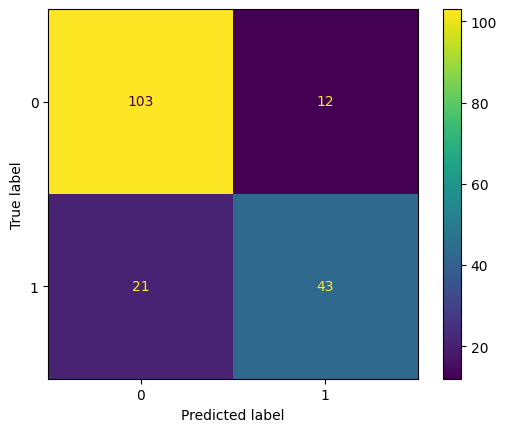

In [35]:
actual = y_test
predicted = y_pred

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [36]:
print(metrics.classification_report(y_test, y_pred, target_names={'Did not Survive', 'Survived'}))

                 precision    recall  f1-score   support

       Survived       0.83      0.90      0.86       115
Did not Survive       0.78      0.67      0.72        64

       accuracy                           0.82       179
      macro avg       0.81      0.78      0.79       179
   weighted avg       0.81      0.82      0.81       179



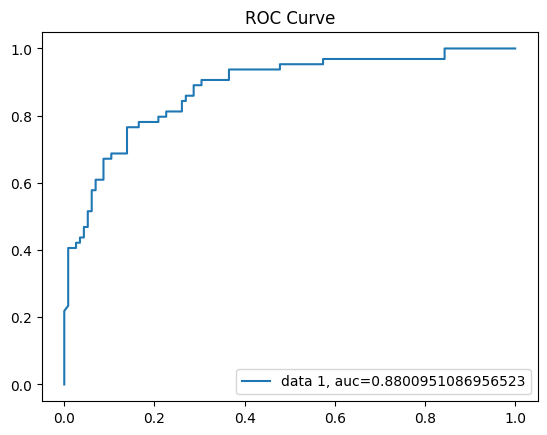

In [37]:
y_pred_proba = log_mod.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.title("ROC Curve")
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [50]:
prediction_eval = log_mod.predict(x_test.iloc[[3]])
print(prediction_eval[0])

0
